In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
       print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce RTX 3080
NVIDIA GeForce RTX 3080
NVIDIA GeForce RTX 3080
NVIDIA GeForce RTX 3080


In [3]:
import ot
import otdd
import numpy as np
from otdd.pytorch.distance import DatasetDistance
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pandas as pd
import argparse
import sys

/home/nguyenpk/miniconda3/envs/resnet_env/lib/python3.9/site-packages/otdd/pytorch/distance.py:23: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
ot.gpu not found - coupling computation will be in cpu


In [4]:
import os
import random
import time
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from sklearn.svm import LinearSVC as _LinearSVC
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm

In [351]:
sys.path.append("/external1/nguyenpham/code/uncertainty_shapley/our_method")
from my_gpytorch import settings
from my_gpytorch import utils
from my_gpytorch.kernels import *
import os
import re
from uncertainty_framework import Shapley_value
import scipy.stats as stats
import math 
from sklearn.metrics import mean_squared_error

In [6]:
# MODIFY LATER
directory_path= "/external1/nguyenpham/code/Develop_uncertainty/output"
pattern = r"calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed(\d+)_ey-1_eta_0.5.pickle"

# List all files in the directory
all_files = os.listdir(directory_path)

# Apply the regex to filter the files
matching_files = [f for f in all_files if re.search(pattern, f)]

# Print the matching files
for i in matching_files:
    print(i)


pattern = r"_seed(\d+)_"
seed_numbers = [int(re.search(pattern, filename).group(1)) for filename in matching_files]

# Print the extracted seed numbers
print(seed_numbers)

def return_seed_avail(path, directory_path, ds_name, model, random, active, ey, eta):
    ifile = "{}_{}_r{}_a{}_seed(\d+)_ey{}_eta_{}".format()
    all_files = os.listdir(directory_path)
    pattern = r"_seed(\d+)_"
    seed_numbers = [int(re.search(pattern, filename).group(1)) for filename in all_files if re.search(text_reg, filename)]
    return seed_numbers

calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed6_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed0_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed3_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed7_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed10_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed9_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed5_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed4_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed2_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed8_ey-1_eta_0.5.pickle
calihouse_iid_4_Exponential_SW_Kernel_r2_a0_seed1_ey-1_eta_0.5.pickle
[6, 0, 3, 7, 10, 9, 5, 4, 2, 8, 1]


In [203]:

def list_A_wth_B(A, B):
    """ """
    return list(set(A) - set(B))

def rCn(n,r):
    f = math.factorial
    return  (f(r)*f(n-r-1))/f(n)
    
def sublist(lst1, lst2):
    return set(lst1) <= set(lst2)

def possible_combined(idx, n_parties):
    ll = []
    A = utils.possible_coalitions(n_parties)
    for i in utils.from_coalition_to_list(A):
        if sublist(idx, i):
            ll.append(i)
    return ll

def return_index(i_coalition, all_coaltion):
    return np.where(np.abs(all_coaltion - i_coalition).sum(axis = 1) == 0)[0][0]
    
def i_shapley_values(v, n_parties, idx ):
    """
    Check again shapley value here
    """
    A = utils.possible_coalitions(n_parties)
    poss = possible_combined(idx, n_parties)
    Sh =  0
    for sub_list in poss:
        idx_include = return_index(utils.from_list_to_coalitions(sub_list, n_parties)[0], A)
        v_incl = v[idx_include]
        exclude_list = list_A_wth_B(sub_list, idx)
        if len(exclude_list) == 0:
            v_excl = 0
            idx_exclude = -1
        else:
            idx_exclude = return_index(utils.from_list_to_coalitions(exclude_list, n_parties)[0], A)
            v_excl = v[idx_exclude]
        k = len(exclude_list)
        if v_incl < 0:
            v_incl = 0
        if v_excl < 0:
            v_excl = 0
        i_S = rCn(n_parties, len(exclude_list))*(v_incl - v_excl)
        # if i_S < 0:
        #     i_S = 0
        # print(sub_list, exclude_list)
        # print(idx_include, idx_exclude)
        # print(v_incl,v_excl, i_S)
        Sh += i_S
    if Sh < 0:
        Sh = 0
    return Sh

def Shapley_value(v_values, n_parties):
    Actual_shapley = np.zeros(n_parties)
    for i in range(n_parties):
        Actual_shapley[i] = i_shapley_values(v_values, n_parties, [i] )
    return Actual_shapley

In [204]:
def return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta):
    file_m = f"{ds_name}_{kernel}_r{ir}_a{ia}_seed{s}_ey{ey}_eta_{eta}.pickle"
    if kernel=='neural_network_':
        file_m = f"{ds_name}_{kernel}_r{ir}_a{ia}_seed{s}.pickle"
    file_a = f"{ds_name}_Exponential_SW_Kernel_r0_a0_seed{s}_ey2_eta_0.5.pickle"
    pdf_m = pd.read_pickle(os.path.join(directory_path, file_m))
    pdf_a = pd.read_pickle(os.path.join(directory_path, file_a))
    ## -------------------------------------
    v_actual = pdf_a['v']
    t_actual = pdf_a["time"]
    n_ = len(pdf_a["Shapley"])
    shapley_actual = Shapley_value(v_actual, n_)
    
    v_m = pdf_m['v']
    t_m = pdf_m["time"]
    shapley_m = pdf_m["Shapley"][-len(shapley_actual):]
    
    mse_v = mean_squared_error(v_actual, v_m)
    kendal_tau = stats.kendalltau(shapley_actual, shapley_m).statistic
    pearson_shapley = stats.pearsonr(shapley_actual, shapley_m).statistic
    pearson_v = stats.pearsonr(v_actual, v_m).statistic
    
    rs = [ir, ia, s, ey, eta, mse_v, pearson_v, kendal_tau, pearson_shapley, t_m, t_actual]
    return rs

### SWEL
# directory_path = "/external1/nguyenpham/code/Develop_uncertainty/output/"
# ds_name = "moon_ds_4_parties"
directory_path = "/external1/nguyenpham/code/uncertainty_shapley/output/"
ds_name = "mnist_non_iid_6"
kernel = "Exponential_SW_Kernel"

random_seed = list(range(10))
nr = [8, 16, 32, 40, 48, 56]
ia = 0
ey= 2
eta=0.5
ll = []
for s in random_seed:
    for ir in nr:
        ia = 0
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
        

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs0 = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': 'mean', 't_actual': 'mean'})

rs0.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_actual']
rs0 = rs0.reset_index()
rs0["method"] = "SWW"



In [205]:
random_seed = list(range(10))
nr = [4, 8,12,16,20,24,28]
ia = 0
ey= 2
eta=0.5
ll = []
for s in random_seed:
    for ir in nr:
        ia = ir
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
        

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs0_a = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': 'mean', 't_actual': 'mean'})

rs0_a.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_actual']
rs0_a = rs0_a.reset_index()
rs0_a["method"] = "SWW-a"

In [206]:
### otdd
# directory_path = "/external1/nguyenpham/code/Develop_uncertainty/output/"
ds_name = "mnist_non_iid_6"
kernel = "My_OTDD_SW_Kernel"

random_seed = list(range(10))
nr = [8, 16, 32, 40, 48, 56]
ia = 0
ey= 0
eta=0.5
ll = []
for s in random_seed:
    for ir in nr:
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
        

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs1 = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': 'mean', 't_actual': 'mean'})

rs1.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_actual']
rs1 = rs1.reset_index()
rs1["method"] = "GP-binary"

In [208]:
random_seed = list(range(10))
nr = [4, 8,12,16,20,24,28]
ia = 0
ey= 0
eta=0.5
ll = []
for s in random_seed:
    for ir in nr:
        ia = ir
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
        

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs1_a = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': 'mean', 't_actual': 'mean'})

rs1_a.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_actual']
rs1_a = rs1_a.reset_index()
rs1_a["method"] = "GP-binary-a"

In [215]:
## base 
kernel = "base"
nr = [8, 16, 32, 40, 48, 56]
random_seed = list(range(10))
ey= 0
eta=0.5
ia=0
ll = []
for s in random_seed:
    for ir in nr:
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
        

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs5 = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': ['mean', 'std'], 't_actual': ['mean', 'std']})

rs5.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_std', 't_actual', 't_actual_std']
rs5 = rs5.reset_index()
rs5["method"] = "OTDD"

In [216]:
### SWEL - etra 0.8
kernel = "base"

random_seed = list(range(10))
ey= 0
eta=0.5
ia=0
nr_a = [4, 8,12,16,20,24,28]
ll = []
for s in random_seed:
    for ir in nr_a:
        ia = ir
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
   

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs5_a = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': ['mean', 'std'], 't_actual': ['mean', 'std']})

rs5_a.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_std', 't_actual', 't_actual_std']
rs5_a = rs5_a.reset_index()
rs5_a["method"] = "OTDD-a"

In [217]:
def return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta):
    file_m = f"{ds_name}_{kernel}_r{ir}_a{ia}_seed{s}_ey{ey}_eta_{eta}.pickle"
    if kernel=='neural_network_':
        file_m = f"{ds_name}_{kernel}_r{ir}_a{ia}_seed{s}.pickle"
    file_a = f"{ds_name}_Exponential_SW_Kernel_r0_a0_seed{s}_ey2_eta_0.5.pickle"
    pdf_m = pd.read_pickle(os.path.join(directory_path, file_m))
    pdf_a = pd.read_pickle(os.path.join(directory_path, file_a))
    ## -------------------------------------
    v_actual = pdf_a['v']
    t_actual = pdf_a["time"]
    n_ = len(pdf_a["Shapley"])
    shapley_actual = Shapley_value(v_actual, n_)
    
    v_m = pdf_m['v']
    t_m = pdf_m["time"]
    shapley_m = pdf_m["Shapley"]
    if kernel=='neural_network_':
        v_m=v_m.squeeze()
        shapley_m = Shapley_value(v_m, n_)
    mse_v = mean_squared_error(v_actual, v_m)
    kendal_tau = stats.kendalltau(shapley_actual, shapley_m).statistic
    pearson_shapley = stats.pearsonr(shapley_actual, shapley_m).statistic
    pearson_v = stats.pearsonr(v_actual, v_m).statistic
    
    rs = [ir, ia, s, ey, eta, mse_v, pearson_v, kendal_tau, pearson_shapley, t_m, t_actual]
    return rs

In [218]:
## base 
kernel = "neural_network_"
nr = [8, 16, 32, 40, 48, 56]
random_seed = list(range(10))
ey= 0
eta=0.5
ia=0
ll = []
for s in random_seed:
    for ir in nr:
        rs  = return_metrics(directory_path, ds_name, kernel, ir, s, ia, ey, eta)
        ll.append(rs)
        

pdf = pd.DataFrame(ll)
pdf.columns = ["random", "active", "seed", "ey", "eta", "mse", "pearson", "kendal_tau_v", "kendal_tau_shapley", "t_m", "t_actual"]

keys = ["random", "active", "ey", "eta"]
rs6 = pdf.groupby(keys).agg({'mse':['mean','std'],  'pearson':['mean','std'], 'kendal_tau_shapley':['mean','std'], 't_m': ['mean', 'std'], 't_actual': ['mean', 'std']})

rs6.columns = ['mse_mean', 'mse_std', 'pearson_mean', 'pearson_std', 'kendall_mean', 'kendall_std', 't_m', 't_std', 't_actual', 't_actual_std']
rs6 = rs6.reset_index()
rs6["method"] = "NN-binary"

In [241]:
# pdf_rs = pd.concat([rs0, rs1, rs2, rs3, rs4, rs5,
#                     rs0_a, rs1_a, rs2_a, rs3_a, rs4_a, rs5_a
#                    ])
pdf_rs = pd.concat([rs0, rs1, rs5, rs6,
                    rs0_a, rs1_a, rs5_a,
                   ])

pdf_rs["round"] = pdf_rs["random"] + pdf_rs["active"]


In [243]:
%matplotlib inline

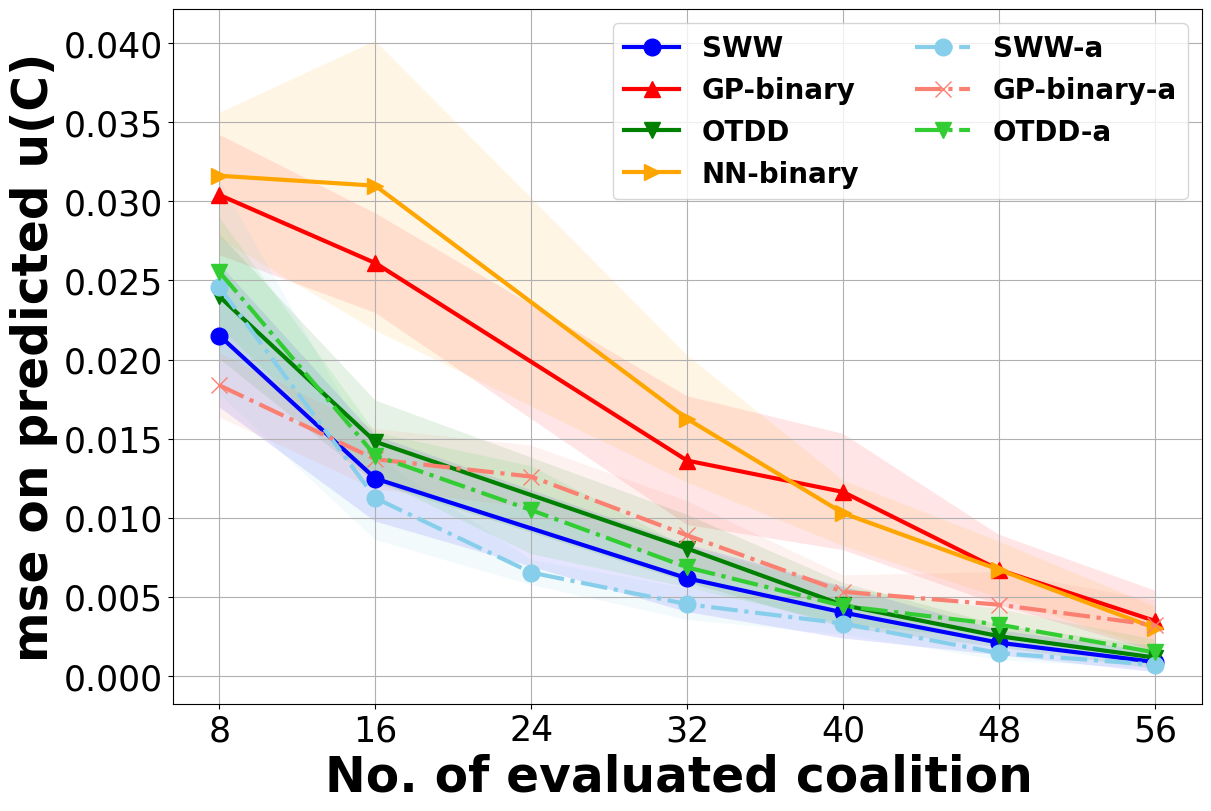

In [244]:
%matplotlib inline
from mycolorpy import colorlist as mcp
import matplotlib.font_manager as font_manager
methods = [i for i in pdf_rs["method"].unique()]
list_possible_marker = ['o',  '^', '.', '>', 's', 'v', 'x','s',]
m_method = dict(zip(methods,list_possible_marker))

c_method = {
    'SWW': 'blue', 
    'OTDD': 'green',
    'NN-binary': 'orange', 
    'GP-binary': 'red',

    'SWW-a': 'skyblue', 
    'OTDD-a': 'limegreen',
    'GP-binary-a': 'salmon',

}
l_method = {
    'SWW': 'solid' ,
    'OTDD': 'solid', 
    'GP-binary': 'solid',
    'NN-binary': 'solid',
    
    'SWW-a': 'dashdot', 
    'OTDD-a': 'dashdot',
    'GP-binary-a': 'dashdot', 

}
m_method = {
    'SWW': 'o' ,
    'OTDD': 'v', 
    'GP-binary': '^',
    'NN-binary': '>',
    
    'SWW-a': 'o', 
    'OTDD-a': 'v',
    'GP-binary-a': 'x', 

}


fig, ax = plt.subplots(figsize=(12,8), layout='constrained')
for i_method in methods:
    idf  = pdf_rs[pdf_rs["method"] == i_method]
    mse = idf["mse_mean"].values
    x = idf["round"]
    std = idf['mse_std']/2
    ax.plot(x, mse, label=i_method, c=c_method[i_method], marker=m_method[i_method], linestyle=l_method[i_method], lw=,markersize=12)
    ax.fill_between(x, mse+std, mse-std ,alpha=0.1, facecolor=c_method[i_method])
    ax.set_xticks(x) 
# ax.hlines(0, 2, xmax=14, linestyles='--', color='purple',lw=5, label='evaluated all')
ax.legend(prop=font_manager.FontProperties(
                               weight='bold',
                               style='normal', size=20), loc="best", ncol=2)

# ax.set_yscale('log')
# ax.set_ylim(-0.001, 0.05)
ax.set_xlabel("No. of evaluated coalition ", fontsize=35,  weight="bold")
ax.set_ylabel("mse on predicted u(C)", fontsize=35, weight="bold")
ax.tick_params(axis='x', labelsize=25,  )
ax.tick_params(axis='y', labelsize=25, )
ax.grid(visible=True)
plt.savefig(f"../plots/{ds_name}_mse.png", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

# PERSON

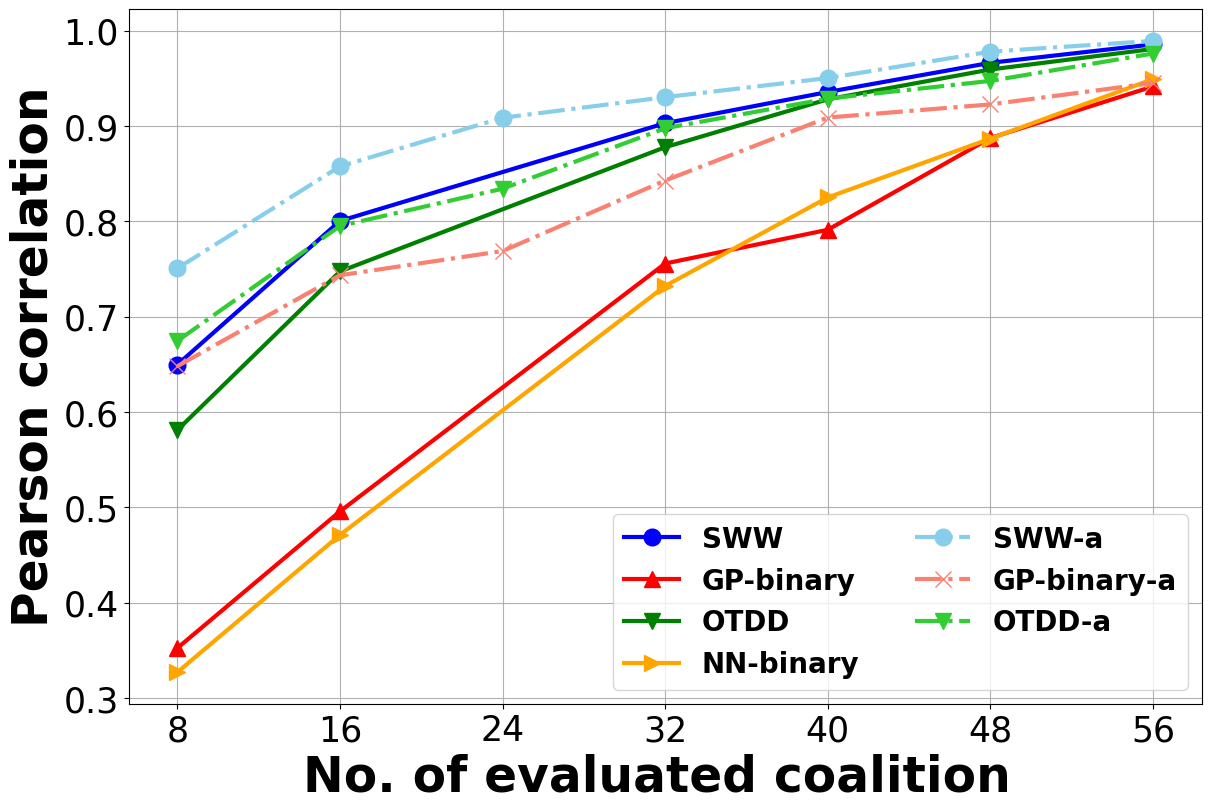

In [245]:
from mycolorpy import colorlist as mcp

label_map = {}
metric_name = "pearson_mean"
#
fig, ax = plt.subplots(figsize=(12,8), layout='constrained')
for i_method in methods:
    idf  = pdf_rs[pdf_rs["method"] == i_method]
    metric = idf[metric_name].values
    
    x = idf["round"]
    std = idf['pearson_std']
    ax.plot(x, metric, label=label_map.get(i_method,i_method), c=c_method[i_method], marker=m_method[i_method],linestyle=l_method[i_method], lw=3,markersize=12)
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    ax.set_xticks(x) 
# ax.hlines(1, 2, xmax=14, linestyles='--', color='purple',lw=5, label='evaluated all')
ax.legend(prop=font_manager.FontProperties(
                               weight='bold',
                               style='normal', size=20), loc="best", ncol=2)
# ax.set_ylim(0, 1.01)
ax.set_xlabel("No. of evaluated coalition ", fontsize=35,  weight="bold")
ax.set_ylabel("Pearson correlation", fontsize=35, weight="bold")
ax.tick_params(axis='x', labelsize=25,  )
ax.tick_params(axis='y', labelsize=25, )
ax.grid(visible=True)
plt.savefig(f"../plots/{ds_name}_corr.png", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

## TIME

In [268]:
pdf_rs = pd.concat([rs0, rs1, rs5, rs6,
                    rs0_a, rs1_a, rs5_a,
                   ])

pdf_rs["round"] = pdf_rs["random"] + pdf_rs["active"]

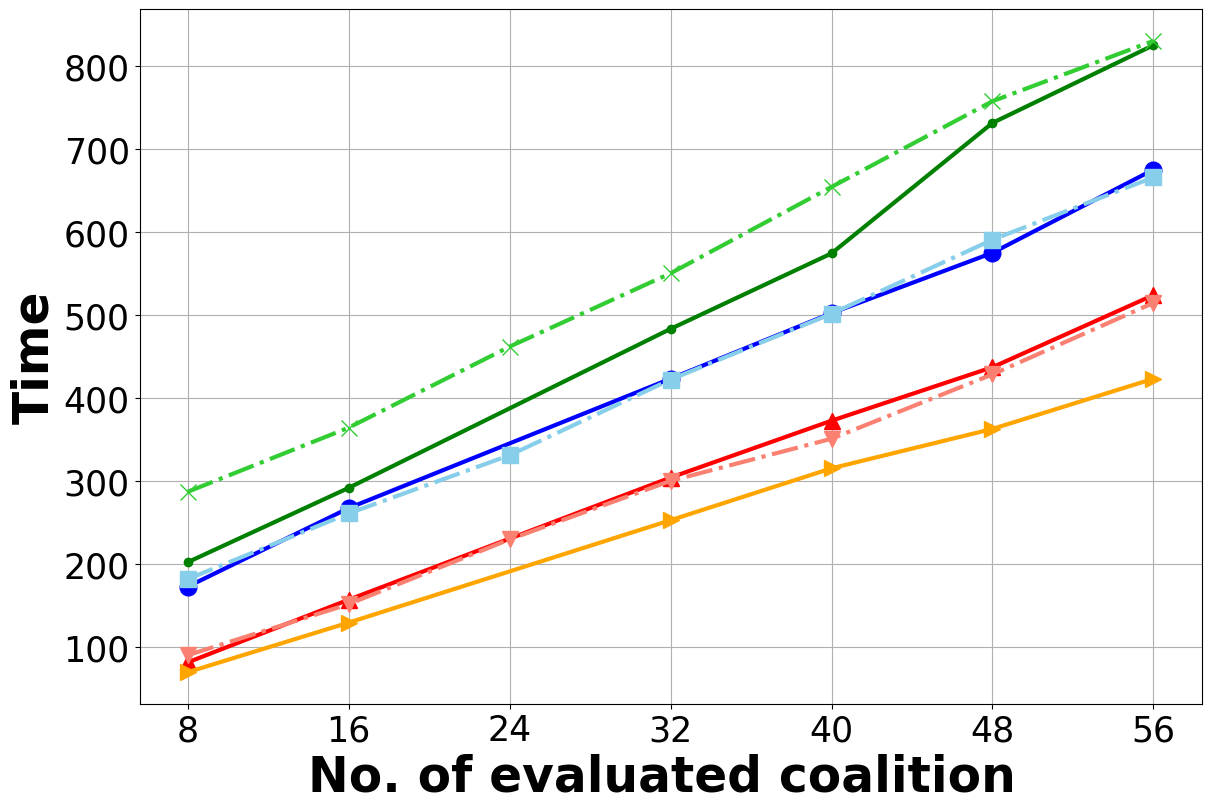

In [270]:
from mycolorpy import colorlist as mcp

# time_actual = max(pdf_rs["t_actual"].values)
time_actual = 15.5

metric_name = "t_m"
#
fig, ax = plt.subplots(figsize=(12,8), layout='constrained')
for i_method in methods:
    idf  = pdf_rs[(pdf_rs["method"] == i_method) ] #& (pdf_rs["round"] < 14)
    metric = idf[metric_name].values
    
    x = idf["round"]
    # std = idf['std']
    ax.plot(x, metric, label=label_map.get(i_method,i_method), c=c_method[i_method], marker=m_method[i_method], lw=3,markersize=12, linestyle=l_method[i_method])
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    
    
    ax.set_xticks(x) 
# ax.hlines(time_actual, 2, xmax=12, linestyles='--', color='purple',lw=5, label='evaluated all')
# ax.legend(prop=font_manager.FontProperties(
#                                weight='bold',
#                                style='normal', size=20), loc="best", ncol=2)
# ax.set_ylim(0, 600)
ax.set_xlabel("No. of evaluated coalition ", fontsize=35,  weight="bold")
ax.set_ylabel("Time", fontsize=35, weight="bold")
ax.tick_params(axis='x', labelsize=25,  )
ax.tick_params(axis='y', labelsize=25, )
ax.grid(visible=True)
plt.savefig(f"../plots/{ds_name}_time.png", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

## KENDALL TAU

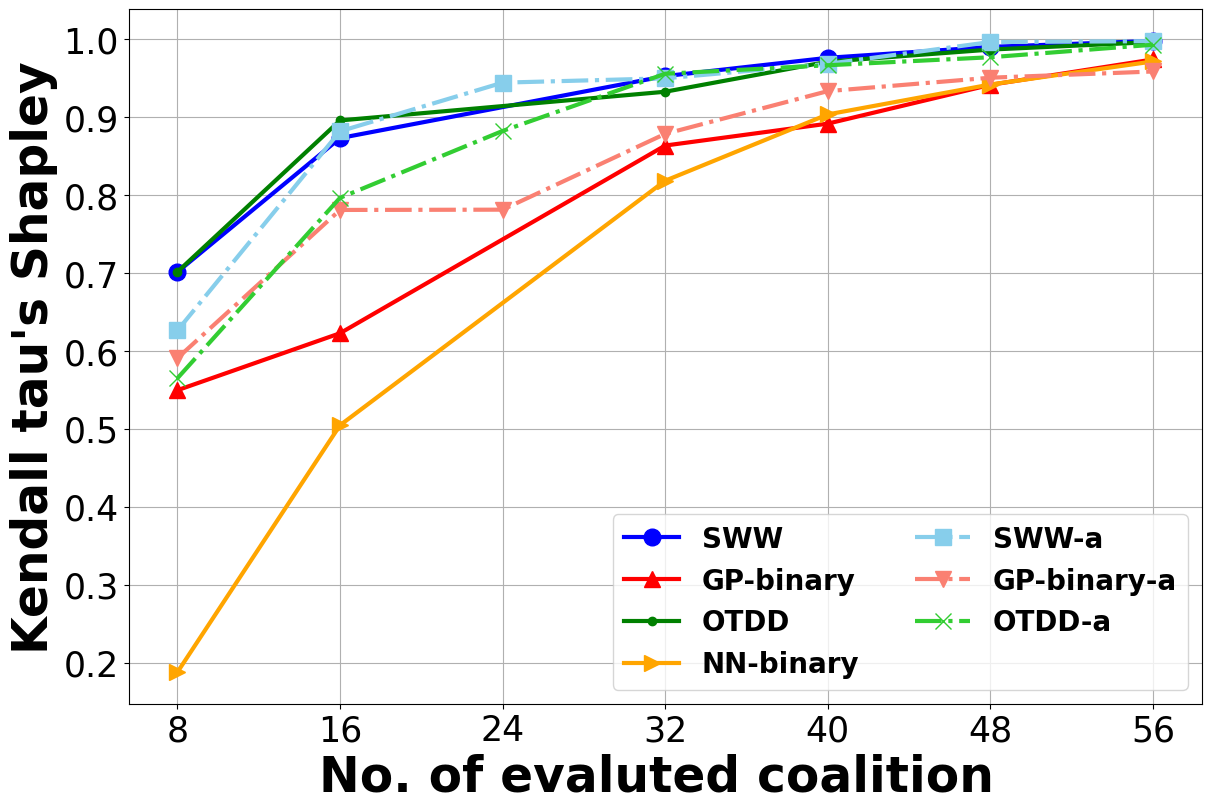

In [274]:
from mycolorpy import colorlist as mcp

# methods = [i for i in pdf_rs["method"].unique() if i != 'OTDD_Bures']
# color= ['green', 'orange', 'blue', 'red', 'purple']
# list_possible_marker = ['o',  '^', '.', '>', 's', 'v', 'x','s',]
# light_color = mcp.gen_color(cmap="Set3",n=len(methods))
# l_method = dict(zip(methods,light_color))

# #
# c_method = dict(zip(methods,color))
# m_method = dict(zip(methods,list_possible_marker))
# l_method = dict(zip(methods,light_color))
# light_color = mcp.gen_color(cmap="tab10_r",n=len(methods))
# l_method = dict(zip(methods,light_color))


# pdf_a = pdf_rs.copy()

metric_name = "kendall_mean"
#
fig, ax = plt.subplots(figsize=(12,8), layout='constrained')
for i_method in methods:
    idf  = pdf_rs[pdf_rs["method"] == i_method]
    metric = idf[metric_name].values
    metric = sorted(metric)
    
    x = idf["round"]
    # std = idf['std']
    ax.plot(x, metric, label=label_map.get(i_method,i_method), c=c_method[i_method], marker=m_method[i_method], lw=3,markersize=12, linestyle=l_method[i_method])
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    
    
    ax.set_xticks(x) 
# ax.hlines(1, 2, xmax=14, linestyles='--', color='purple',lw=5, label='evaluated all')
ax.legend(prop=font_manager.FontProperties(
                               weight='bold',
                               style='normal', size=20), loc="best", ncol=2)
# ax.set_ylim(-.5, 1.02)
ax.set_xlabel("No. of evaluted coalition ", fontsize=35,  weight="bold")
ax.set_ylabel("Kendall tau's Shapley", fontsize=35, weight="bold")
ax.tick_params(axis='x', labelsize=25,  )
ax.tick_params(axis='y', labelsize=25, )
ax.grid(visible=True)
plt.savefig(f"../plots/{ds_name}_kendall_tau.png", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

In [275]:
%matplotlib inline

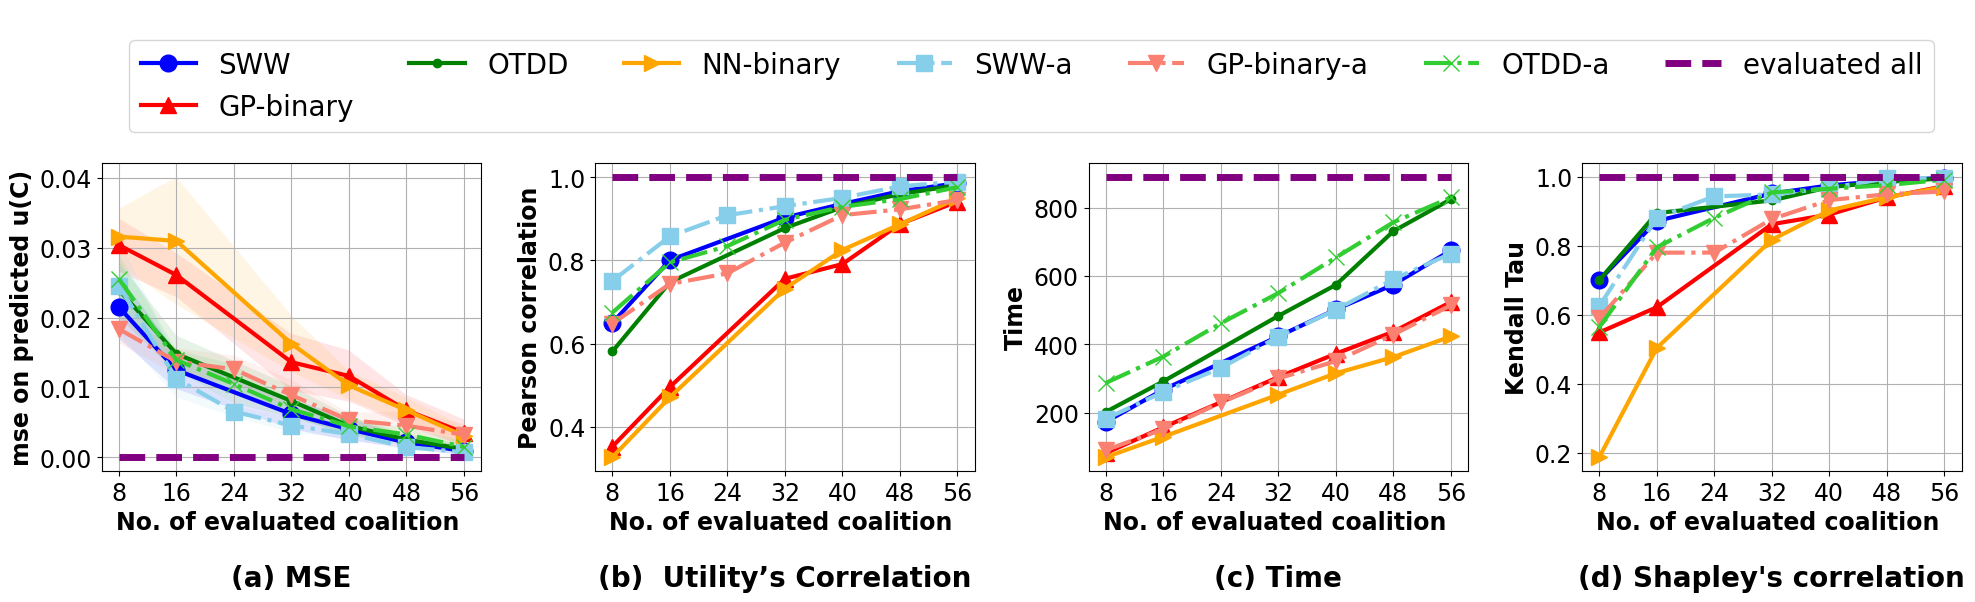

In [277]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

from mycolorpy import colorlist as mcp
import matplotlib.font_manager as font_manager
methods = [i for i in pdf_rs["method"].unique()]
list_possible_marker = ['o',  '^', '.', '>', 's', 'v', 'x','s',]
m_method = dict(zip(methods,list_possible_marker))

fontsize = 17
labelsize = 17
title_size = 20
# Create a GridSpec with 2 rows and 4 columns
fig = plt.figure(figsize=(24, 6))
heights = [2, 4]
gs = fig.add_gridspec(ncols=4, nrows=2,
                          height_ratios=heights)


# Create subplots in the first row
axes = []

for j in range(4):  # Columns 0 to 3
    ax = fig.add_subplot(gs[1, j])
    axes.append(ax)

### MSE
ax = axes[0]
for i_method in methods:
    idf  = pdf_rs[pdf_rs["method"] == i_method]
    mse = idf["mse_mean"].values
    x = idf["round"]
    std = idf['mse_std']/2
    axes[0].plot(x, mse, label=i_method, c=c_method[i_method], marker=m_method[i_method], linestyle=l_method[i_method], lw=3,markersize=12)
    axes[0].fill_between(x, mse+std, mse-std ,alpha=0.1, facecolor=c_method[i_method])
    axes[0].set_xticks(x) 
axes[0].hlines(0, 8, xmax=56, linestyles='--', color='purple',lw=5, label='evaluated all')

axes[0].set_xlabel("No. of evaluated coalition ", fontsize=fontsize,  weight="bold")
axes[0].set_ylabel("mse on predicted u(C)", fontsize=fontsize, weight="bold")
axes[0].tick_params(axis='x', labelsize=labelsize,  )
axes[0].tick_params(axis='y', labelsize=labelsize, )
axes[0].set_title("(a) MSE", fontsize=title_size, weight="bold", y=-0.4)
axes[0].grid(visible=True)

# plt.savefig(f"{ds_name}_mse.png", format="pdf", bbox_inches='tight', dpi=300)

### PEARSON
ax=axes[1]
metric_name = "pearson_mean"
#
for i_method in methods:
    idf  = pdf_rs[pdf_rs["method"] == i_method]
    metric = idf[metric_name].values
    
    x = idf["round"]
    std = idf['pearson_std']
    ax.plot(x, metric, c=c_method[i_method], marker=m_method[i_method],linestyle=l_method[i_method], lw=3,markersize=12)
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    ax.set_xticks(x) 
ax.hlines(1, 8, xmax=56, linestyles='--', color='purple',lw=5)

ax.set_xlabel("No. of evaluated coalition ", fontsize=fontsize,  weight="bold")
ax.set_ylabel("Pearson correlation", fontsize=fontsize, weight="bold")
ax.tick_params(axis='x', labelsize=labelsize,  )
ax.tick_params(axis='y', labelsize=labelsize, )
ax.set_title("(b)  Utility’s Correlation", fontsize=title_size, weight="bold", y=-0.4)

ax.grid(visible=True)


### TIME
ax = axes[2]
time_actual = 15.5

metric_name = "t_m"
#
for i_method in methods:
    idf  = pdf_rs[(pdf_rs["method"] == i_method) ] #& (pdf_rs["round"] < 14)
    metric = idf[metric_name].values
    
    x = idf["round"]
    # std = idf['std']
    ax.plot(x, metric, c=c_method[i_method], marker=m_method[i_method], lw=3,markersize=12, linestyle=l_method[i_method])
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    
    
    ax.set_xticks(x) 
ax.hlines(time_ac, 8, xmax=56, linestyles='--', color='purple',lw=5 )
ax.set_xlabel("No. of evaluated coalition ", fontsize=fontsize,  weight="bold")
ax.set_ylabel("Time", fontsize=fontsize, weight="bold")
ax.tick_params(axis='x', labelsize=labelsize,  )
ax.tick_params(axis='y', labelsize=labelsize, )
ax.set_title("(c) Time", fontsize=title_size, weight="bold", y=-0.4)
ax.grid(visible=True)

### KENDALL TAU
ax = axes[3]
metric_name = "kendall_mean"
#
for i_method in methods:
    idf  = pdf_rs[pdf_rs["method"] == i_method]
    metric = idf[metric_name].values
    metric = sorted(metric)
    
    x = idf["round"]
    # std = idf['std']
    ax.plot(x, metric,  c=c_method[i_method], marker=m_method[i_method], lw=3,markersize=12, linestyle=l_method[i_method])
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    
    
ax.set_xticks(x) 
ax.hlines(1, 8, xmax=56, linestyles='--', color='purple',lw=5 )
ax.set_xlabel("No. of evaluated coalition ", fontsize=fontsize,  weight="bold")
ax.set_ylabel("Kendall Tau", fontsize=fontsize, weight="bold")
ax.tick_params(axis='x', labelsize=labelsize,  )
ax.tick_params(axis='y', labelsize=labelsize, )
ax.set_title("(d) Shapley's correlation", fontsize=title_size, weight="bold", y=-0.4)
ax.grid(visible=True)

handles = []
labels = []

for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a dedicated legend axes
legend_ax = fig.add_subplot(gs[0, :])  # Row 1, all columns
legend_ax.axis('off')  # Hide axes frame

# Add the shared legend
legend_ax.legend(handles, labels, loc='center', ncol=7, fontsize=20)


# Adjust layout
plt.subplots_adjust(hspace=0., wspace=0.3)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95, hspace=0, wspace=0.25)
# plt.savefig(f"{ds_name}_all.png", format="pdf", bbox_inches='tight', dpi=300)
# plt.subplots_adjust(top=0.83)
plt.savefig(f"{ds_name}_all.png", format="pdf", bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

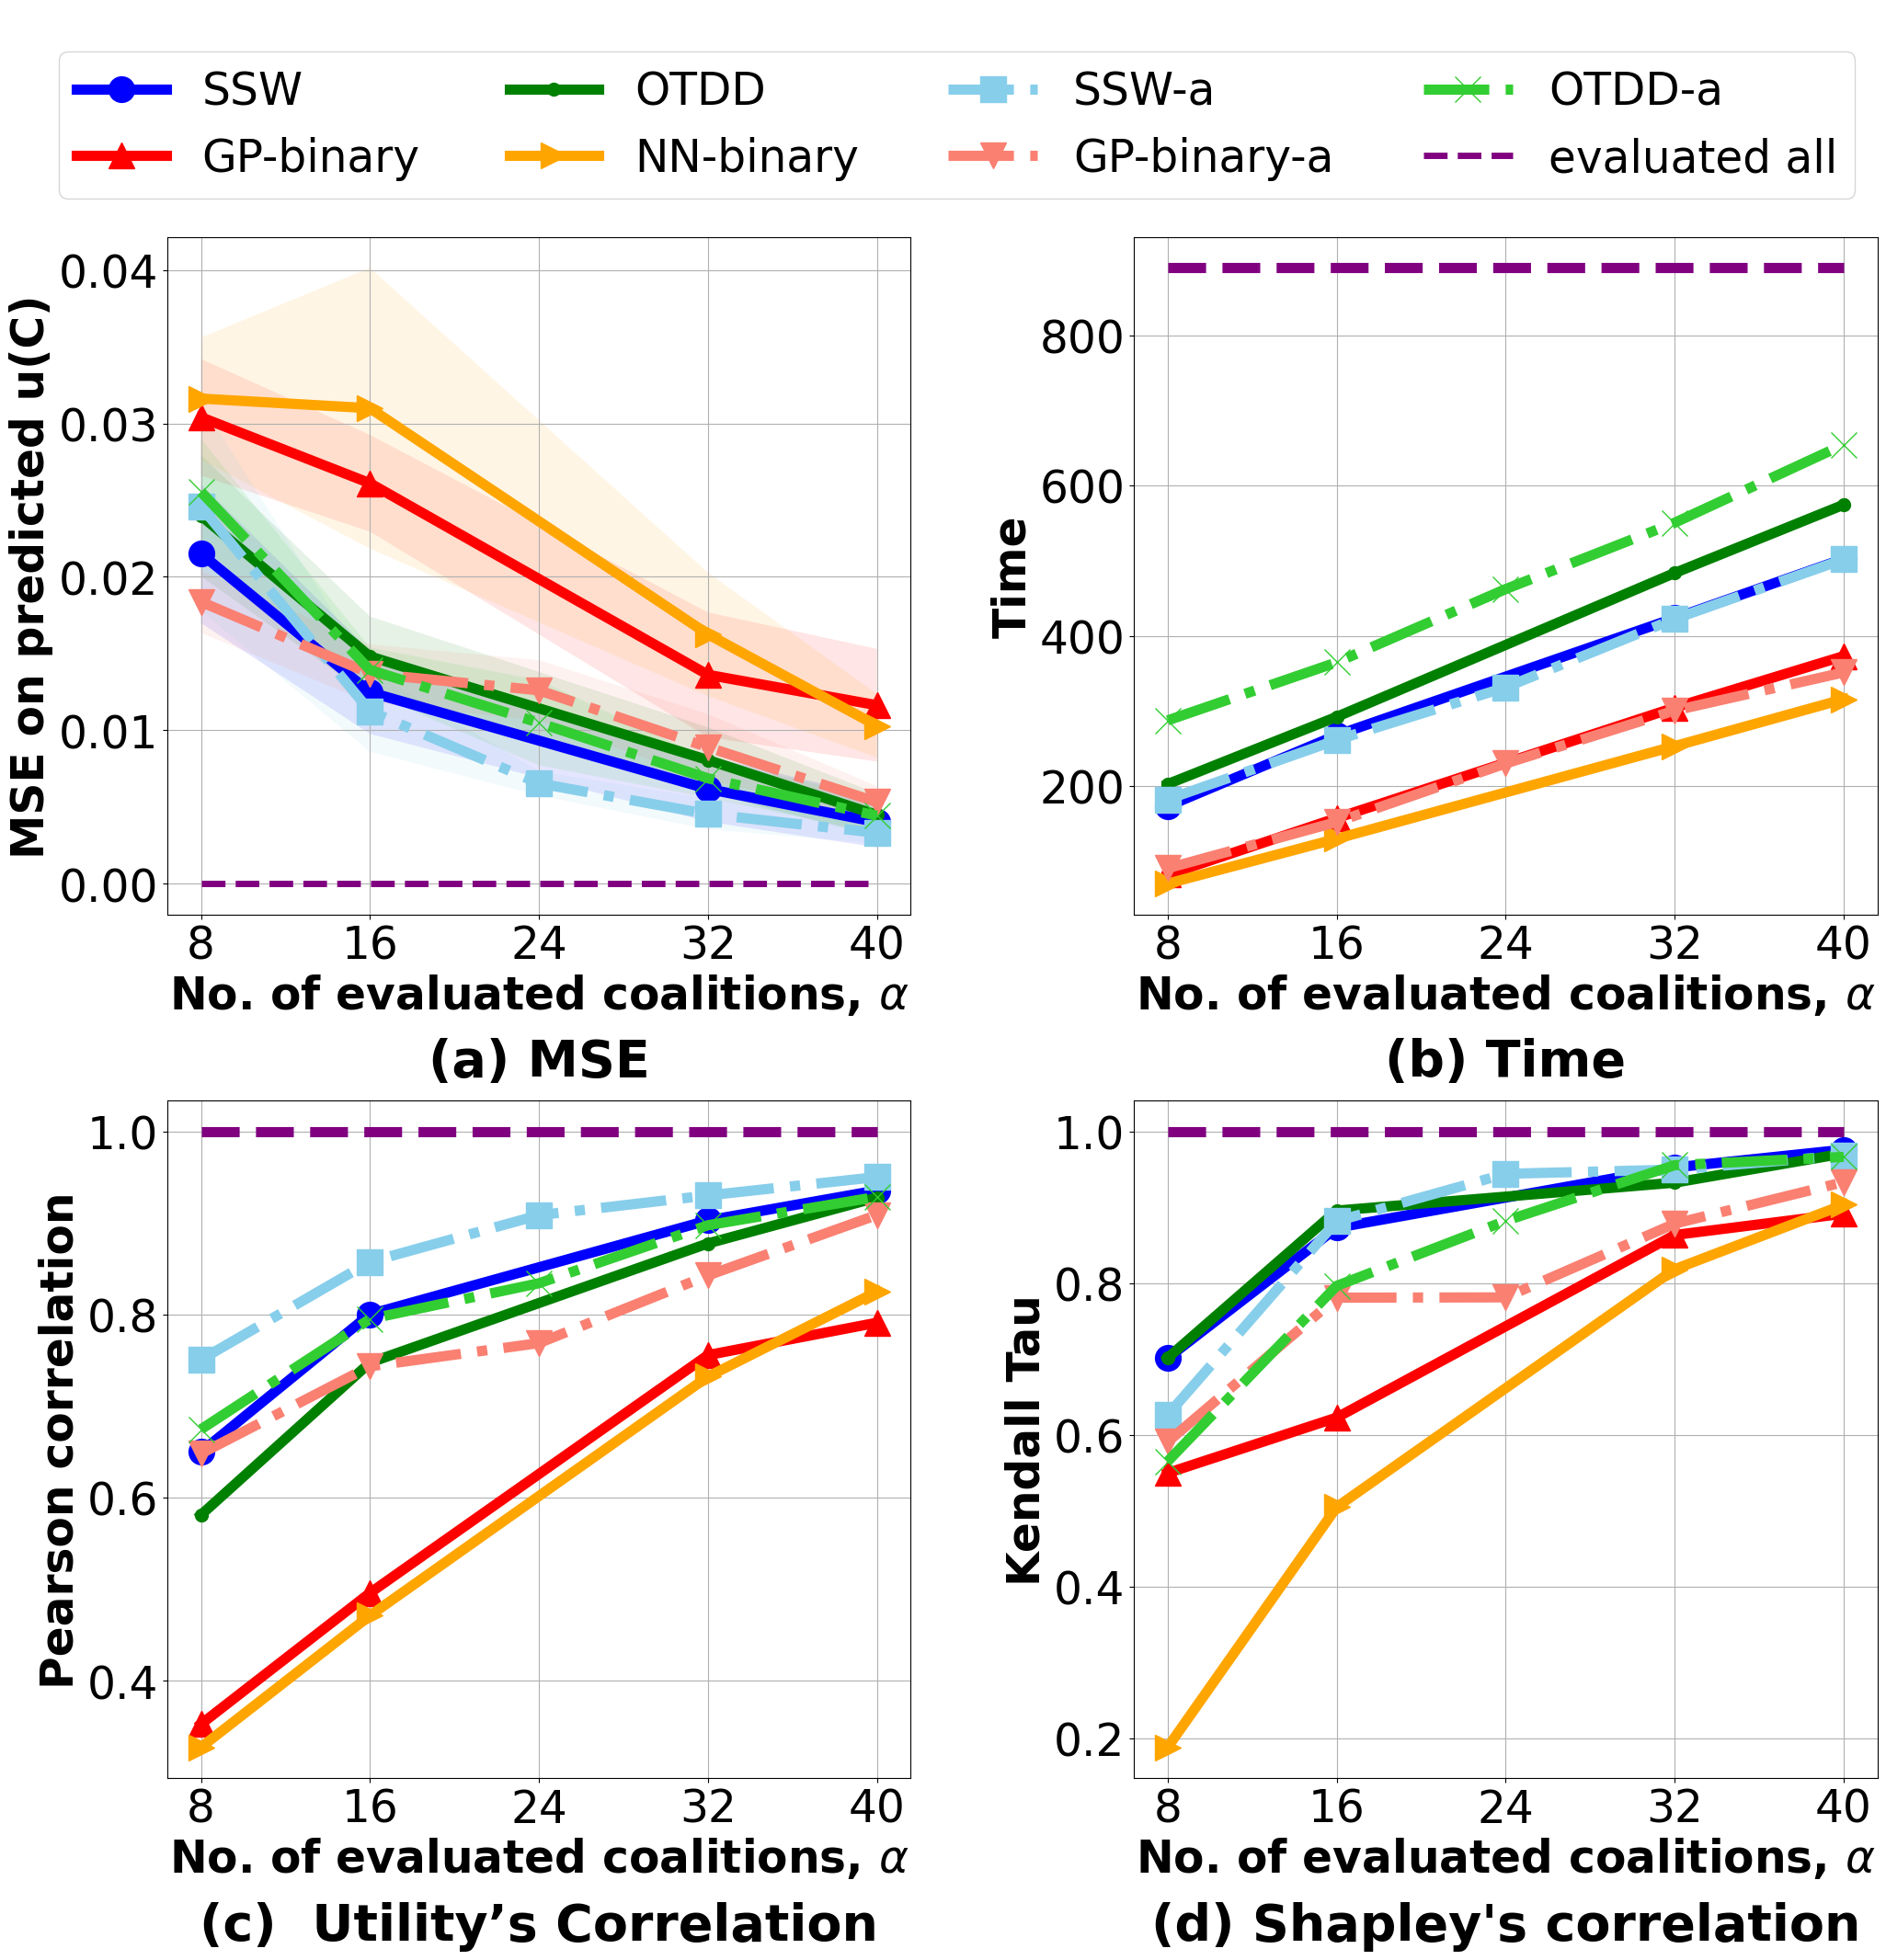

In [358]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

from mycolorpy import colorlist as mcp
import matplotlib.font_manager as font_manager
methods = [i for i in pdf_rs["method"].unique()]
list_possible_marker = ['o',  '^', '.', '>', 's', 'v', 'x','s',]
m_method = dict(zip(methods,list_possible_marker))

label_map = {'SWW':'SSW', 'SWW-a':'SSW-a'}
fontsize = 35
labelsize = 35
title_size = 40
lw=8
mz=20
yl = -0.25
# Create a GridSpec with 2 rows and 4 columns
fig = plt.figure(figsize=(24, 25))
heights = [0.75, 12, 12]
gs = fig.add_gridspec(ncols=2, nrows=3,
                          height_ratios=heights)

max_x = 40
x_title = "No. of evaluated coalitions, $\\alpha$"
# Create subplots in the first row
axes = []

for j in range(2):  # Columns 0 to 3
    ax = fig.add_subplot(gs[1, j])
    axes.append(ax)
    #
    ax = fig.add_subplot(gs[2, j])
    axes.append(ax)

### MSE
ax = axes[0]
for i_method in methods:
    idf  = pdf_rs[(pdf_rs["method"] == i_method) & (pdf_rs["round"] <= max_x)]
    mse = idf["mse_mean"].values
    x = idf["round"]
    std = idf['mse_std']/2
    axes[0].plot(x, mse, label=label_map.get(i_method,i_method), c=c_method[i_method], marker=m_method[i_method], linestyle=l_method[i_method], lw=lw,markersize=mz)
    axes[0].fill_between(x, mse+std, mse-std ,alpha=0.1, facecolor=c_method[i_method])
    axes[0].set_xticks(x) 
axes[0].hlines(0, 8, xmax=max_x, linestyles='--', color='purple',lw=5, label='evaluated all')

axes[0].set_xlabel(x_title, fontsize=fontsize,  weight="bold")
axes[0].set_ylabel("MSE on predicted u(C)", fontsize=fontsize, weight="bold")
axes[0].tick_params(axis='x', labelsize=labelsize,  )
axes[0].tick_params(axis='y', labelsize=labelsize, )
axes[0].set_title("(a) MSE", fontsize=title_size, weight="bold", y=yl)
axes[0].grid(visible=True)

# plt.savefig(f"{ds_name}_mse.png", format="pdf", bbox_inches='tight', dpi=300)

### PEARSON
ax=axes[1]
metric_name = "pearson_mean"
#
for i_method in methods:
    idf  =  pdf_rs[(pdf_rs["method"] == i_method) & (pdf_rs["round"] <= max_x)]
    metric = idf[metric_name].values
    
    x = idf["round"]
    std = idf['pearson_std']
    ax.plot(x, metric, c=c_method[i_method], marker=m_method[i_method],linestyle=l_method[i_method], lw=lw,markersize=mz)
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    ax.set_xticks(x) 
ax.hlines(1, 8, xmax=max_x, linestyles='--', color='purple',lw=lw)

ax.set_xlabel(x_title, fontsize=fontsize,  weight="bold")
ax.set_ylabel("Pearson correlation", fontsize=fontsize, weight="bold")
ax.tick_params(axis='x', labelsize=labelsize,  )
ax.tick_params(axis='y', labelsize=labelsize, )
ax.set_title("(c)  Utility’s Correlation", fontsize=title_size, weight="bold", y=yl)

ax.grid(visible=True)


### TIME
ax = axes[2]

metric_name = "t_m"
#
for i_method in methods:
    idf  = pdf_rs[(pdf_rs["method"] == i_method) & (pdf_rs["round"] <= max_x)]
    metric = idf[metric_name].values
    
    x = idf["round"]
    # std = idf['std']
    ax.plot(x, metric, c=c_method[i_method], marker=m_method[i_method], lw=lw,markersize=mz, linestyle=l_method[i_method])
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    
    
    ax.set_xticks(x) 
ax.hlines(time_ac, 8, xmax=max_x, linestyles='--', color='purple',lw=lw )
ax.set_xlabel(x_title, fontsize=fontsize,  weight="bold")
ax.set_ylabel("Time", fontsize=fontsize, weight="bold")
ax.tick_params(axis='x', labelsize=labelsize,  )
ax.tick_params(axis='y', labelsize=labelsize, )
ax.set_title("(b) Time", fontsize=title_size, weight="bold", y=yl)
ax.grid(visible=True)

### KENDALL TAU
ax = axes[3]
metric_name = "kendall_mean"
#
for i_method in methods:
    idf  = pdf_rs[(pdf_rs["method"] == i_method) & (pdf_rs["round"] <= max_x)]
    metric = idf[metric_name].values
    metric = sorted(metric)
    
    x = idf["round"]
    # std = idf['std']
    ax.plot(x, metric,  c=c_method[i_method], marker=m_method[i_method], lw=lw,markersize=mz, linestyle=l_method[i_method])
    # ax.fill_between(x, metric+std, metric-std ,alpha=0.2, facecolor=c_method[i_method])
    
    
ax.set_xticks(x) 
ax.hlines(1, 8, xmax=max_x, linestyles='--', color='purple',lw=lw )
ax.set_xlabel(x_title, fontsize=fontsize,  weight="bold")
ax.set_ylabel("Kendall Tau", fontsize=fontsize, weight="bold")
ax.tick_params(axis='x', labelsize=labelsize,  )
ax.tick_params(axis='y', labelsize=labelsize, )
ax.set_title("(d) Shapley's correlation", fontsize=title_size, weight="bold", y=yl)
ax.grid(visible=True)

handles = []
labels = []

for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a dedicated legend axes
legend_ax = fig.add_subplot(gs[0, :])  # Row 1, all columns
legend_ax.axis('off')  # Hide axes frame

# Add the shared legend
# legend_ax.legend(handles, labels, loc='center', ncol=4, fontsize=fontsize) #bbox_to_anchor=(0.5, 1.0)
legend_ax.legend(handles, labels, bbox_to_anchor=(1., 0.5), ncol=4, fontsize=fontsize)

# Adjust layout
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# plt.subplots_adjust(top=0.9, bottom=0.08, left=0.05, right=0.95, hspace=0.4, wspace=0.25)
# plt.savefig(f"{ds_name}_all.png", format="pdf", bbox_inches='tight', dpi=300)
# plt.subplots_adjust(top=0.83)
plt.savefig(f"{ds_name}_all.png", format="pdf", bbox_inches='tight', dpi=300)

# Display the plot
plt.show()